In [1]:
import torch
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

from base import SelfAttn, W_svm_solver

In [2]:
# if cross_attn is True, then we use cross attention
# if cross_attn is False, then we use self attention (i.e. set z_i = x_{i,atten_idx})
cross_attn = True
attn_idx = 0
lr = 0.1

n = 2
d = 2
T = 5

ITN = 2000
eps = torch.finfo(torch.double).eps

# True: W-parametrization
# False: (K, Q)-parametrization
univariates = [True, False]

Ws = np.zeros((2, ITN+1, d, d))

# generate data for better visualization
def data_generator():
    seed = 3
    generator = torch.Generator()
    generator.manual_seed(seed)
    v = torch.randn((d), generator=generator)
    v /= torch.norm(v)
    Y = torch.ones(n)

    X = 0.5 * torch.randn((n, T, d), generator=generator)
    X[0,0] = torch.tensor([1,.5])
    X[1,0] = torch.tensor([1,-0.5])
    X[:,1:] += torch.tensor([-1,0])
    Z = torch.randn((n, d), generator=generator)
    Z /= torch.norm(Z, dim=-1, keepdim=True)
    best_ids = ((X @ v) * Y.view(-1,1)).argmax(dim=-1)
    return X, Y, Z, v, best_ids

In [3]:
# data generation
X, Y, Z, v, best_ids = data_generator()
X, Y, Z, v = X.double(), Y.double(), Z.double(), v.double()
# global SVM solution
sol_fro = W_svm_solver(X, best_ids, cross_input=Z, attn_idx=attn_idx, cross_attn=cross_attn, fro=True)
sol_nuc = W_svm_solver(X, best_ids, cross_input=Z, attn_idx=attn_idx, cross_attn=cross_attn, fro=False)
for i in range(len(univariates)):
    univariate = univariates[i]
    model = SelfAttn(d, univariate=univariate).double()
    model.v.data = v
    if univariate:
        model.W.weight.data *= 0
        params = [model.W.weight]
    else:
        model.query.weight.data *= 0
        model.key.weight.data = 0.1* torch.randn_like(model.key.weight.data).double()
        params = [model.query.weight, model.key.weight]
    optimizer = torch.optim.SGD(params, lr=lr)
    for it in range(ITN):
        optimizer.zero_grad()
        out = model(X, cross_input=Z, attn_idx=attn_idx, cross_attn=cross_attn).view(-1)
        loss = torch.log(1+torch.exp(-Y*out))
        loss = loss.mean()
        if univariate is False:
            loss += eps * (model.key.weight.norm()**2+model.query.weight.norm()**2)
        loss.backward()
        if univariate:
            model.W.weight.grad /= (model.W.weight.grad.norm()+eps)
        else:
            model.key.weight.grad /= ((model.key.weight.grad.norm())+eps)
            model.query.weight.grad /= ((model.query.weight.grad.norm())+eps)
        optimizer.step()

        W = model.W.weight.detach().T if univariate else model.query.weight.T.mm(model.key.weight).T.detach()
        Ws[i, it+1] = W.numpy()

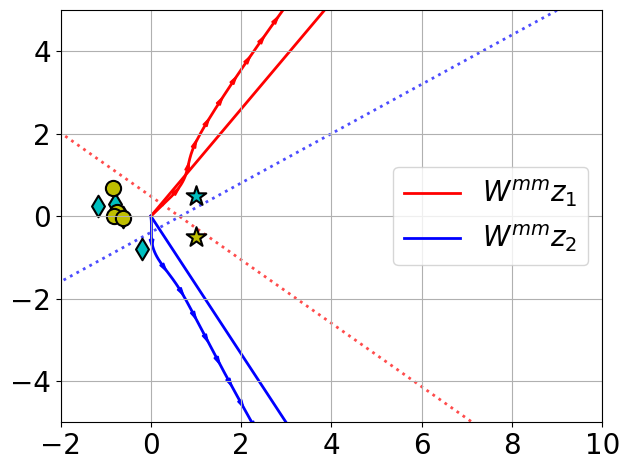

In [4]:
W_param = True
markers = ['d','o']
ss = [120, 120]
colors = ['c','y']
for i in range(n):
    for t in range(T):
        if t == best_ids[i]:
            plt.scatter(X[i,t,0], X[i,t,1], marker='*', color=colors[i],s=220, zorder=2, edgecolors='black', linewidths=1.5)
        else:
            plt.scatter(X[i,t,0], X[i,t,1], marker=markers[i], color=colors[i],s=ss[i], zorder=1, edgecolors='black', linewidths=1.5)

colors = ['r','b']
# plot SVM solution mapped to z_i
if W_param:
    p1f = sol_fro.dot(Z[0])
    p2f = sol_fro.dot(Z[1])
else:
    p1f = sol_nuc.dot(Z[0])
    p2f = sol_nuc.dot(Z[1])
plt.plot([0,p1f[0]*100], [0,p1f[1]*100], color=colors[0], linewidth=2, zorder=0)
plt.plot([0,p2f[0]*100], [0,p2f[1]*100], color=colors[1], linewidth=2, zorder=0)
 
# plot separating hyperplanes
norm1 = npl.norm(p1f)
norm2 = npl.norm(p2f)
p1f_o = -p1f[0]/p1f[1]
p2f_o = -p2f[0]/p2f[1]
b1 = -(X[0,0,0] - p1f[0]/norm1/norm1/2) * p1f_o + (X[0,0,1] - p1f[1]/norm1/norm1/2)
b2 = -(X[1,0,0] - p2f[0]/norm2/norm2/2) * p2f_o + (X[1,0,1] - p2f[1]/norm2/norm2/2)
plt.plot([-100,100], [-100*p1f_o+b1,100*p1f_o+b1], color=colors[0], linestyle=':', linewidth=2, zorder=-2, alpha=0.7)
plt.plot([-100,100], [-100*p2f_o+b2,100*p2f_o+b2], color=colors[1], linestyle=':', linewidth=2, zorder=-2, alpha=0.7)


# plot GD trajectories mapped to z_i
THRED = 2000
arrow_size = .2
if W_param:
    ps1f = Ws[0].dot(Z[0])
    ps2f = Ws[0].dot(Z[1])
    K = 10
    label = [r'$W^{mm} z_1$',r'$W^{mm} z_2$']
else:
    ps1f = Ws[1].dot(Z[0])
    ps2f = Ws[1].dot(Z[1])
    K = 4
    label = [r'$W^{mm}_\star z_1$',r'$W^{mm}_\star z_2$']
lf1,=plt.plot(ps1f[:,0][:THRED], ps1f[:,1][:THRED], linewidth=2, linestyle='-', color='red', zorder=-1)
lf2,=plt.plot(ps2f[:,0][:THRED], ps2f[:,1][:THRED], linewidth=2, linestyle='-', color='blue', zorder=-1)
for j in range(THRED):
    if (j+1) % K == 0:
        plt.arrow((ps1f[j,0]), (ps1f[j,1]), (ps1f[j+1,0]-ps1f[j,0]), (ps1f[j+1,1]-ps1f[j,1]), length_includes_head=False,head_width=arrow_size/2, head_length=arrow_size, color='red', zorder=-1)
        plt.arrow((ps2f[j,0]), (ps2f[j,1]), (ps2f[j+1,0]-ps2f[j,0]), (ps2f[j+1,1]-ps2f[j,1]), length_includes_head=False,head_width=arrow_size/2, head_length=arrow_size, color='blue', zorder=-1)


plt.xlim([-2,10])
plt.ylim([-5,5])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(label, fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()